In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("melb_data.csv")

# Keep only rows where property type is 'h' (house)
df_houses = df[df["Type"] == "h"]

# Count the number of house records for each suburb
suburb_counts = df_houses["Suburb"].value_counts()

# Get the top 3 suburbs with the most houses
top3_suburbs = suburb_counts.head(3).index.tolist()
print("Top 3 suburbs (only houses):", top3_suburbs)

# Filter dataset to keep only these top 3 suburbs
df_selected = df_houses[df_houses["Suburb"].isin(top3_suburbs)].reset_index(drop=True)

# Check the result
print(df_selected["Suburb"].value_counts())
print("Shape:", df_selected.shape)


Top 3 suburbs (only houses): ['Reservoir', 'Preston', 'Bentleigh East']
Suburb
Reservoir         253
Preston           208
Bentleigh East    168
Name: count, dtype: int64
Shape: (629, 21)


In [2]:
import numpy as np

# Keep only the specified columns
df_selected = df_selected[[
    "Suburb",
    "Address",
    "Rooms",
    "Price",
    "Date",
    "Distance",
    "Postcode",
    "Bedroom2",
    "Bathroom",
    "Car",
    "Landsize"
]]

df_selected["SchoolsNearby"] = np.random.randint(1, 4, size=len(df_selected))

# Check result
print(df_selected.head())
print("Shape:", df_selected.shape)


           Suburb           Address  Rooms      Price       Date  Distance  \
0  Bentleigh East      18 Mervin St      2  1410000.0  3/09/2016      13.9   
1  Bentleigh East    30 Veronica St      2   825000.0  3/09/2016      13.9   
2  Bentleigh East      19 Denver St      5  1275000.0  3/12/2016      13.9   
3  Bentleigh East    93 Parkmore Rd      3  1206000.0  3/12/2016      13.9   
4  Bentleigh East  76 Castlewood St      4  1190000.0  4/03/2017      13.9   

   Postcode  Bedroom2  Bathroom  Car  Landsize  SchoolsNearby  
0    3165.0       2.0       1.0  2.0     768.0              3  
1    3165.0       2.0       2.0  1.0     176.0              2  
2    3165.0       5.0       2.0  2.0     683.0              1  
3    3165.0       3.0       1.0  2.0     603.0              3  
4    3165.0       4.0       2.0  3.0     591.0              1  
Shape: (629, 12)


Shape after one-hot encoding: (629, 14)
Numeric features standardized.


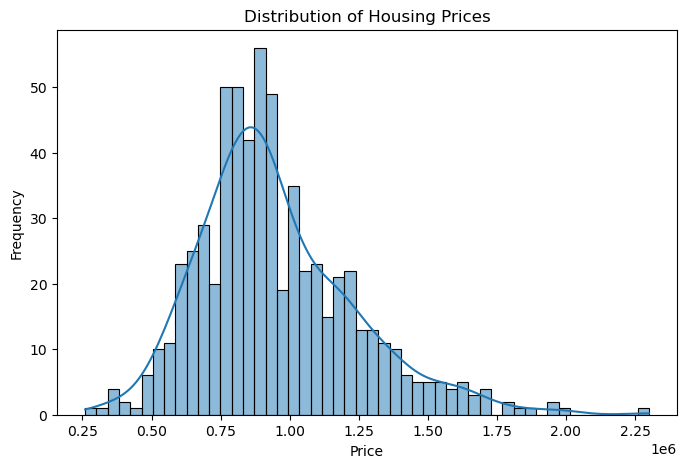

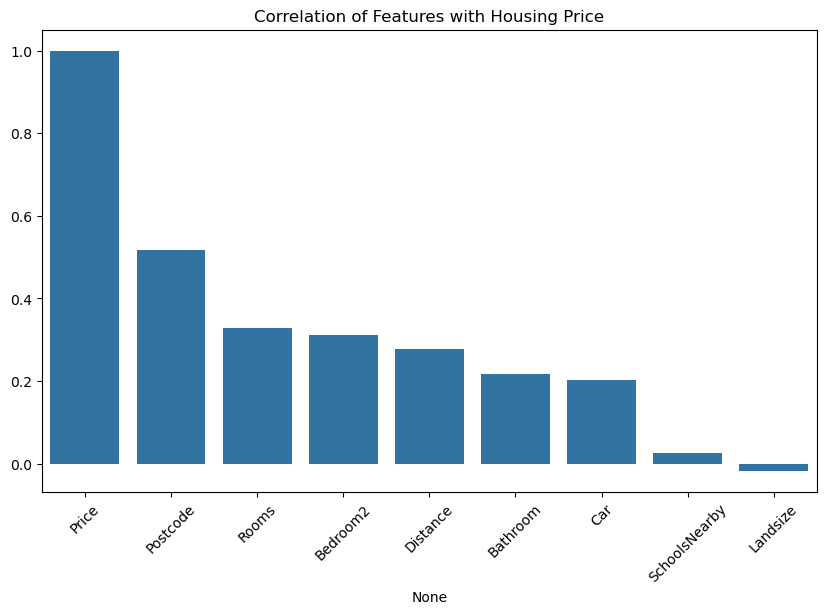

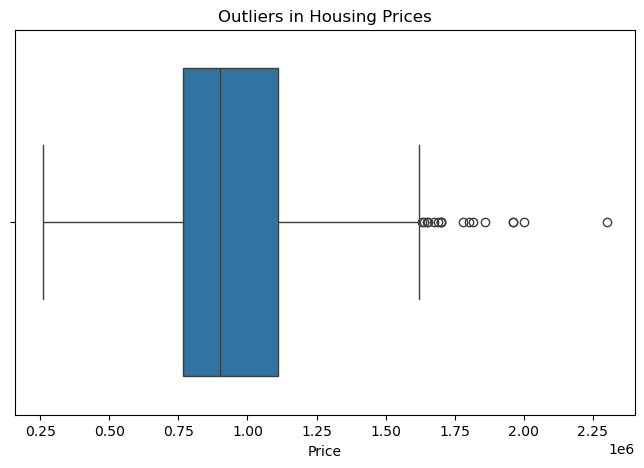

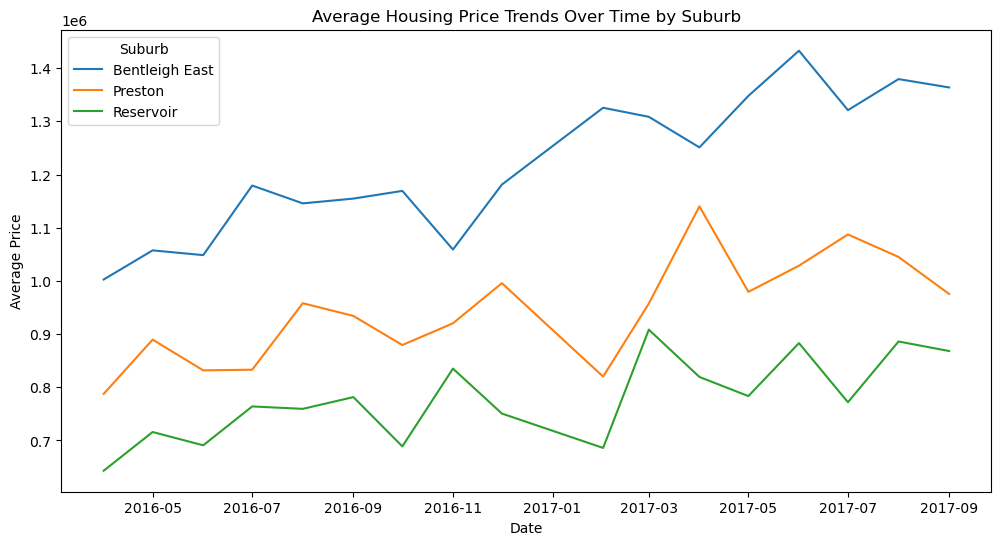

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# ---------------------------
# a. One-hot encode categorical variables
# ---------------------------
# Select categorical columns
categorical_cols = ["Suburb", "Postcode"] 

# One-hot encoding
df_encoded = pd.get_dummies(df_selected, columns=categorical_cols, drop_first=True)

print("Shape after one-hot encoding:", df_encoded.shape)

# ---------------------------
# b. Normalize / standardize numerical features
# ---------------------------
numeric_cols = ["Rooms", "Distance", "Bedroom2", "Bathroom", "Car", "Landsize"]

scaler = StandardScaler()
df_encoded[numeric_cols] = scaler.fit_transform(df_encoded[numeric_cols])

print("Numeric features standardized.")

# ---------------------------
# c. Visualize price distributions
# ---------------------------
plt.figure(figsize=(8,5))
sns.histplot(df_selected["Price"], bins=50, kde=True)
plt.title("Distribution of Housing Prices")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

# ---------------------------
# d. Feature-to-target correlations
# ---------------------------
plt.figure(figsize=(10,6))
correlations = df_selected.corr(numeric_only=True)["Price"].sort_values(ascending=False)
sns.barplot(x=correlations.index, y=correlations.values)
plt.xticks(rotation=45)
plt.title("Correlation of Features with Housing Price")
plt.show()

# ---------------------------
# e. Detect outliers in price using boxplot
# ---------------------------
plt.figure(figsize=(8,5))
sns.boxplot(x=df_selected["Price"])
plt.title("Outliers in Housing Prices")
plt.show()

# ---------------------------
# f. Identify price trends over time across suburbs
# ---------------------------
# Convert Date column to datetime
df_selected["Date"] = pd.to_datetime(df_selected["Date"], dayfirst=True, errors="coerce")

# Group by suburb and month-year
df_trends = df_selected.groupby([df_selected["Suburb"], df_selected["Date"].dt.to_period("M")])["Price"].mean().reset_index()
df_trends["Date"] = df_trends["Date"].dt.to_timestamp()

plt.figure(figsize=(12,6))
sns.lineplot(data=df_trends, x="Date", y="Price", hue="Suburb")
plt.title("Average Housing Price Trends Over Time by Suburb")
plt.ylabel("Average Price")
plt.show()


In [4]:
# ===== Model development: 3 regressors + k-fold CV + MAE/RMSE/R2 =====
# Requirements: pandas, numpy, scikit-learn
# Install if missing: pip install scikit-learn

import pandas as pd
import numpy as np

from sklearn.model_selection import KFold, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score

# ---------------------------
# 1) Prepare DataFrame (ensure Date parsed and drop address)
# ---------------------------
# assume df_selected exists (filtered to chosen suburbs and columns)
# If not, load it from CSV: df_selected = pd.read_csv("your_filtered_file.csv")
df = df_selected.copy()

# Parse Date to datetime if it's not already
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')

# Create simple time features (year and month) from sale Date — can help models capture time trend
df['SaleYear'] = df['Date'].dt.year
df['SaleMonth'] = df['Date'].dt.month

# Drop rows with missing target or major features
df = df.dropna(subset=['Price'])  # ensure we have target
# Optionally drop rows with too many NaNs:
# df = df.dropna(subset=['Rooms','Bedroom2','Bathroom','Car','Landsize','Distance','Postcode'])

# Drop Address column (text address is not useful in this basic pipeline)
if 'Address' in df.columns:
    df = df.drop(columns=['Address'])

# ---------------------------
# 2) Define features and target
# ---------------------------
target_col = 'Price'
# Numeric columns to scale
numeric_cols = ['Rooms', 'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'SaleYear', 'SaleMonth']
# Keep only those that actually exist in df (safe guard)
numeric_cols = [c for c in numeric_cols if c in df.columns]

# Categorical columns to one-hot encode
categorical_cols = ['Suburb']
categorical_cols = [c for c in categorical_cols if c in df.columns]

X = df[numeric_cols + categorical_cols]
y = df[target_col].values

# ---------------------------
# 3) Preprocessing pipeline
# ---------------------------
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    remainder='drop'  # drop any other columns
)

# ---------------------------
# 4) Define models
# ---------------------------
models = {
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=200, random_state=42)
}

# Wrap each model in a Pipeline with preprocessing
pipelines = {name: Pipeline(steps=[('preprocessor', preprocessor), ('model', model)]) 
             for name, model in models.items()}

# ---------------------------
# 5) Cross-validation setup and scorers
# ---------------------------
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# scorers: we will compute MAE, RMSE (from neg_mean_squared_error), and R2
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

scoring = {
    'MAE': make_scorer(mean_absolute_error, greater_is_better=False),  # note: we use negative for cross_validate compatibility
    'MSE': 'neg_mean_squared_error',
    'R2': 'r2'
}

# ---------------------------
# 6) Run cross-validation for each model and summarize results
# ---------------------------
results = []

for name, pipe in pipelines.items():
    print(f"Running CV for {name} ...")
    cv_res = cross_validate(pipe, X, y, cv=kf, scoring=scoring, return_train_score=False, n_jobs=-1)
    
    # extract and transform results
    mae_scores = -cv_res['test_MAE']  # convert back to positive
    mse_scores = -cv_res['test_MSE']
    rmse_scores = np.sqrt(mse_scores)
    r2_scores = cv_res['test_R2']
    
    results.append({
        'model': name,
        'MAE_mean': mae_scores.mean(),
        'MAE_std': mae_scores.std(),
        'RMSE_mean': rmse_scores.mean(),
        'RMSE_std': rmse_scores.std(),
        'R2_mean': r2_scores.mean(),
        'R2_std': r2_scores.std()
    })

# Present results as DataFrame
results_df = pd.DataFrame(results).set_index('model')
# formatting numbers for readability
results_df[['MAE_mean','MAE_std','RMSE_mean','RMSE_std','R2_mean','R2_std']] = results_df[['MAE_mean','MAE_std','RMSE_mean','RMSE_std','R2_mean','R2_std']].round(2)

print("\nCross-Validation Results (5-fold):")
display(results_df)

# ---------------------------
# 7) (Optional) Fit the best model on full data and save it
# ---------------------------
best_model_name = results_df['RMSE_mean'].idxmin()
print(f"\nBest model by CV RMSE: {best_model_name}")

best_pipeline = pipelines[best_model_name]
best_pipeline.fit(X, y)

# Save the trained pipeline for later use (optional)
import joblib
joblib.dump(best_pipeline, 'best_housing_model_pipeline.joblib')
print("Saved best model pipeline to 'best_housing_model_pipeline.joblib'")


Running CV for LinearRegression ...
Running CV for RandomForest ...
Running CV for GradientBoosting ...

Cross-Validation Results (5-fold):


,MAE_mean,MAE_std,RMSE_mean,RMSE_std,R2_mean,R2_std
model,,,,,,
LinearRegression,167307.97,20095.53,307451.53,185615.18,-0.73,2.34
RandomForest,141157.49,4508.24,197187.66,23253.95,0.51,0.08
GradientBoosting,143865.02,5918.79,195954.11,24910.93,0.52,0.08



Best model by CV RMSE: GradientBoosting
Saved best model pipeline to 'best_housing_model_pipeline.joblib'


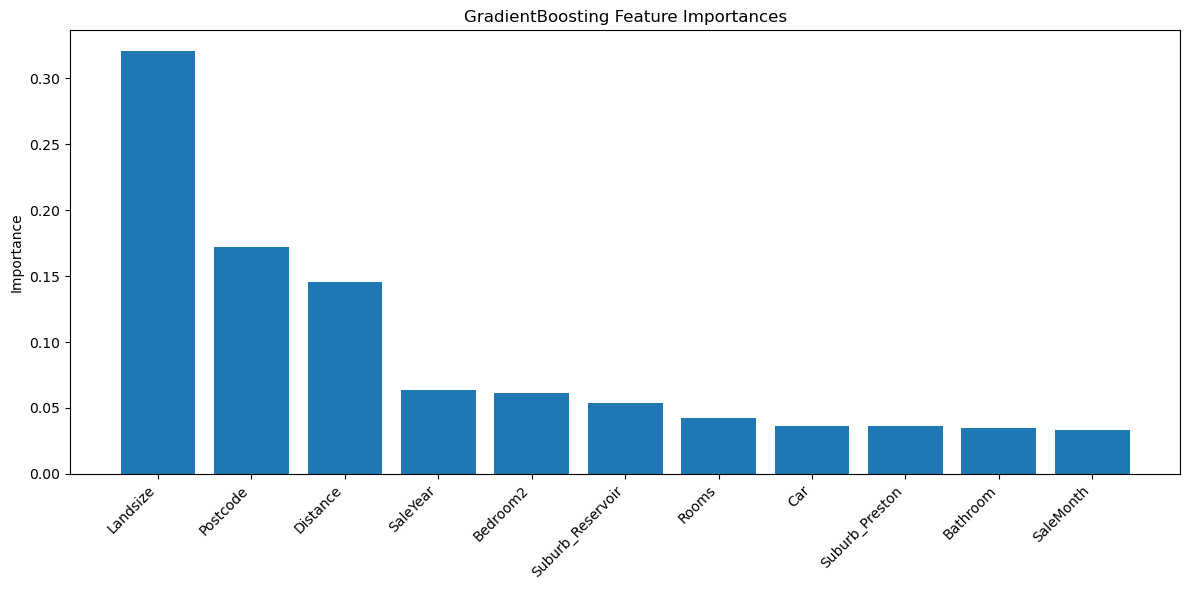

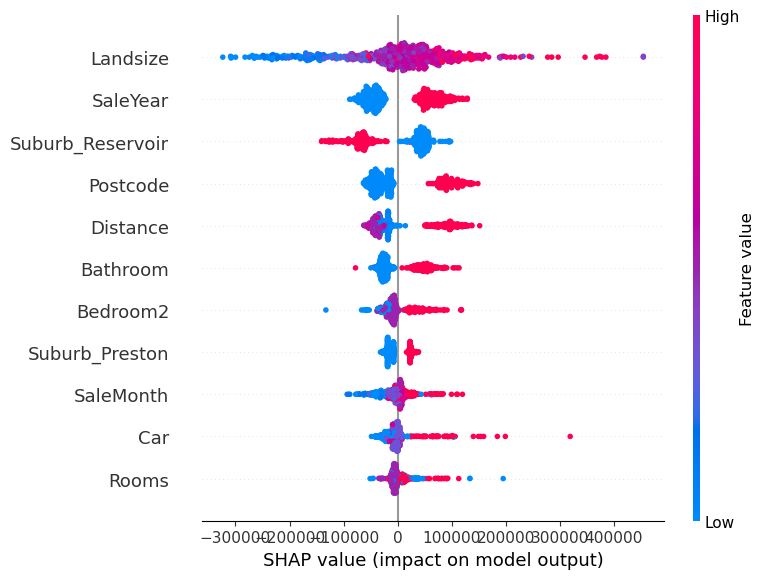

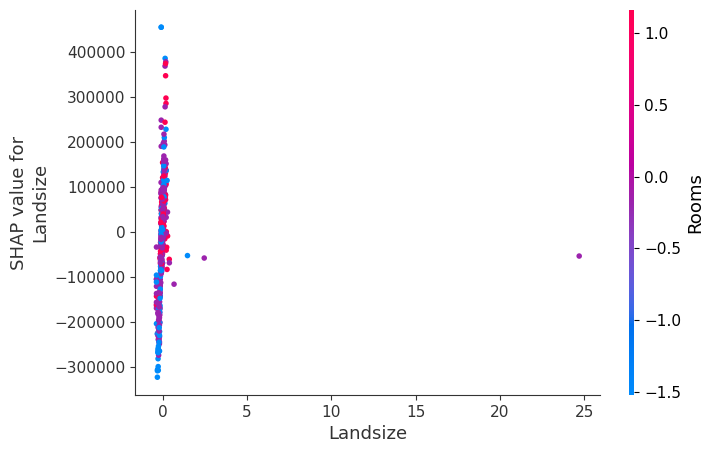

In [5]:
# ===============================
# Feature Importance Analysis
# ===============================

import numpy as np
import matplotlib.pyplot as plt
import shap

# ------------------------------
# 1) Get feature names from the preprocessor
# ------------------------------
# Numeric feature names
num_features = numeric_cols

# Categorical feature names (from one-hot encoder)
cat_features = best_pipeline.named_steps['preprocessor'].transformers_[1][1]\
    .named_steps['onehot'].get_feature_names_out(categorical_cols)

# Combine numeric and categorical feature names
all_features = np.concatenate([num_features, cat_features])

# ------------------------------
# 2) Extract GradientBoosting feature importances
# ------------------------------
importances = best_pipeline.named_steps['model'].feature_importances_

# Sort importances in descending order
indices = np.argsort(importances)[::-1]

# Plot feature importances
plt.figure(figsize=(12,6))
plt.title("GradientBoosting Feature Importances")
plt.bar(range(len(importances)), importances[indices], align='center')
plt.xticks(range(len(importances)), all_features[indices], rotation=45, ha='right')
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

# ------------------------------
# 3) SHAP analysis for deeper interpretation
# ------------------------------
# Create SHAP explainer for the trained GradientBoosting model
explainer = shap.Explainer(best_pipeline.named_steps['model'])

# Transform input features using preprocessor
X_preprocessed = best_pipeline.named_steps['preprocessor'].transform(X)

# Compute SHAP values
shap_values = explainer(X_preprocessed)

# ------------------------------
# 4) Summary plot of SHAP values
# ------------------------------
shap.summary_plot(shap_values, X_preprocessed, feature_names=all_features)

# ------------------------------
# 5) Optional: SHAP dependence plot for a specific feature
# ------------------------------
# Example: Show impact of 'Landsize' on predictions
if 'Landsize' in all_features:
    shap.dependence_plot('Landsize', shap_values.values, X_preprocessed, feature_names=all_features)


In [ ]:
import gradio as gr
import pandas as pd
import joblib

# Load trained pipeline
best_pipeline = joblib.load('best_housing_model_pipeline.joblib')

def predict_price(rooms, bedroom2, bathroom, car, landsize, distance, sale_year, sale_month, suburb, postcode):
    # Create input DataFrame
    input_df = pd.DataFrame({
        "Rooms": [rooms],
        "Bedroom2": [bedroom2],
        "Bathroom": [bathroom],
        "Car": [car],
        "Landsize": [landsize],
        "Distance": [distance],
        "SaleYear": [sale_year],
        "SaleMonth": [sale_month],
        "Suburb": [suburb],
        "Postcode": [postcode] 
    })

    # Ensure numeric columns are float
    numeric_cols = ["Rooms","Bedroom2","Bathroom","Car","Landsize","Distance","SaleYear","SaleMonth","Postcode"]
    input_df[numeric_cols] = input_df[numeric_cols].astype(float)

    # Predict using the trained pipeline
    predicted_price = best_pipeline.predict(input_df)[0]
    return f"AUD ${predicted_price:,.0f}"

# Gradio input components
inputs = [
    gr.Number(label="Number of Rooms", value=2),
    gr.Number(label="Number of Bedrooms", value=2),
    gr.Number(label="Number of Bathrooms", value=1),
    gr.Number(label="Number of Car Spaces", value=2),
    gr.Number(label="Land Size (sqm)", value=768),
    gr.Number(label="Distance to CBD (km)", value=13.9),
    gr.Number(label="Sale Year", value=2016),
    gr.Number(label="Sale Month", value=9),
    gr.Dropdown(label="Suburb", choices=["Reservoir", "Preston", "Bentleigh East"], value="Bentleigh East"),
    gr.Number(label="Postcode", value=3165)
]

outputs = gr.Textbox(label="Predicted House Price")

# Launch Gradio interface
gr.Interface(
    fn=predict_price, 
    inputs=inputs, 
    outputs=outputs,
    title="Melbourne House Price Predictor",
    description="Enter property features to predict the house price in Melbourne."
).launch()
